In [1]:
from sklearn.feature_extraction.text import TfidfVectorizer
import pandas as pd
import os
from xgboost import XGBClassifier
from sklearn.metrics import f1_score, accuracy_score
import json
import numpy as np
from tqdm import tqdm
import xgboost as xgb
import shap
from collections import defaultdict
import warnings
warnings.filterwarnings('ignore')
from collections.abc import MutableMapping
from sklearn.feature_extraction.text import CountVectorizer
import string
import nltk
#nltk.download('punkt')
#nltk.download('stopwords')
from nltk.tokenize import word_tokenize
from nltk.corpus import stopwords
from nltk.stem import PorterStemmer
from sklearn.feature_extraction.text import TfidfVectorizer

C:\Users\elyes\AppData\Local\Programs\Python\Python310\lib\site-packages\tqdm\auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [3]:
valid_texts = pd.read_parquet('data/x_valid_vec.parquet')

In [4]:
def flatten_dict(d: MutableMapping, sep: str= '.') -> MutableMapping:
    [flat_dict] = pd.json_normalize(d, sep=sep).to_dict(orient='records')
    return flat_dict

In [5]:
def build_shap_values(label, sample):
    with open(f'data/{label}/label_mapping.txt') as f:
        content = f.read().replace("'",'"')
        class_names = list(json.loads(content).keys())

    model = xgb.Booster()
    model.load_model(f"models/xgb/{label}.json")
    
    explainer = shap.TreeExplainer(model)
    shap_values = explainer.shap_values(sample.astype(float))
    expected_value= explainer.expected_value
    return explainer, shap_values, expected_value, class_names

In [6]:
def remove_useless_words(texts):
    zero_columns = []
    for column in valid_texts.columns:
        if valid_texts[column].sum() == 0.0:
            zero_columns.append(column)
    return valid_texts.drop(zero_columns,axis=1)

In [7]:
def calculate_word_contribution(texts, classes, shap_values):
    word_contribution = defaultdict(dict)

    for i,word in tqdm(enumerate(texts.columns)):
        for j,classname in enumerate(classes): 
            score=0
            for k in range(16378):
                score += abs(shap_values[j][k][i])
            
            word_contribution[word][classname] = score

    return word_contribution

In [8]:
def remove_zero_words(word_contrib):
    new_contrib = defaultdict(dict)
    for word in list(word_contrib.keys()):
        if np.sum(list(word_contrib[word].values())) == 0.0:
            del word_contrib[word]
    return word_contrib

## SHAP Values generation

In [107]:
%%time
PR_explainer, PR_shap_values, PR_expected_value, PR_class_names = build_shap_values("privilegesRequired", valid_texts)
[print(i,e) for i,e in enumerate(PR_class_names)]

0 HIGH
1 LOW
2 NONE
CPU times: total: 11min 13s
Wall time: 1min 2s


[None, None, None]

In [9]:
%%time
AV_explainer, AV_shap_values, AV_expected_value, AV_class_names = build_shap_values("attackVector", valid_texts)
[print(i,e) for i,e in enumerate(AV_class_names)]

0 ADJACENT_NETWORK
1 LOCAL
2 NETWORK
3 PHYSICAL
CPU times: total: 15min 29s
Wall time: 1min 30s


[None, None, None, None]

In [40]:
AV_shap_values[1][230][0]

0.0

## Word contribution calculation

In [59]:
%%time
AV_word_contrib = calculate_word_contribution(valid_texts, AV_class_names, AV_shap_values)
print(len(AV_word_contrib))
AV_word_contib = remove_zero_words(AV_word_contrib)
print(len(AV_word_contrib))

15000it [07:50, 31.85it/s]


15000
1483
CPU times: total: 7min 49s
Wall time: 7min 51s


In [60]:
with open("data/word_contribution_attack_vector.json","w") as f:
    f.write(json.dumps(AV_word_contrib))

In [108]:
PR_word_contrib = calculate_word_contribution(valid_texts, PR_class_names, PR_shap_values)
print(len(AV_word_contrib))
PR_word_contrib = remove_zero_words(PR_word_contrib)
print(len(AV_word_contrib))

15000it [04:47, 52.13it/s]

1483
1483


In [1]:
with open("data/word_contribution_privilege_escalation.json","w") as f:
    f.write(json.dumps(AV_word_contrib))

NameError: name 'json' is not defined

## Word analysis

In [111]:
# with open("data/word_contribution_privilege_escalation.json","r") as f:
#     pe_wc = json.loads(f.read())

In [61]:
with open("data/word_contribution_attack_vector.json","r") as f:
    av_wc = json.loads(f.read())

In [62]:
# Return only the words that are found in only one class
exclusively = pd.DataFrame(columns=['word','class','score'])

for word,class_scores in list(av_wc.items()):
    scores = list(av_wc[word].values())
    sum = np.sum(scores)
    
    if sum in scores:
        index = scores.index(sum)
        exclusively.loc[len(exclusively)] = [word, list(class_scores.keys())[index], list(class_scores.values())[index]]

In [20]:
exclusively[exclusively['class'] == "PHYSICAL"].sample(10)

,word,class,score
482,passcode,PHYSICAL,38.945442
142,camera,PHYSICAL,45.707560
22,21892,PHYSICAL,0.406458
775,zephyrproject,PHYSICAL,2.399262
153,changing,PHYSICAL,10.903842
469,opensc,PHYSICAL,18.457236
644,spoofed,PHYSICAL,26.078166
462,nxp,PHYSICAL,2.751572
126,bitlocker,PHYSICAL,37.333996
398,lock,PHYSICAL,354.887113


In [63]:
descriptions = pd.read_csv('data/raw_cves.csv', usecols=['cve.descriptions.lang.en'])

In [17]:
descriptions

,cve.descriptions.lang.en
0,"The debug command in Sendmail is enabled, allo..."
1,CWD ~root command in ftpd allows root access.
2,Buffer overflow in passwd in BSD based operati...
3,Vulnerability in restore in SunOS 4.0.3 and ea...
4,Vulnerability in rcp on SunOS 4.0.x allows rem...
...,...
197750,The VK All in One Expansion Unit WordPress plu...
197751,The ProfileGrid WordPress plugin before 5.3.1 ...
197752,Cross-site Scripting (XSS) - DOM in GitHub rep...
197753,HTML Email Injection in Tribe29 Checkmk <=2.1....


In [64]:
from sklearn.feature_extraction.text import CountVectorizer

# Create CountVectorizer object
vectorizer = CountVectorizer()

# Learn the vocabulary dictionary and transform the corpus into a document-term matrix
X = vectorizer.fit_transform(descriptions['cve.descriptions.lang.en'])

# Get the frequency count of each word in the vocabulary
word_freq = X.sum(axis=0)

# Convert the sparse matrix to a numpy array
word_freq_array = word_freq.A[0]

# Create a dictionary of word frequencies
word_freq_dict = dict(zip(vectorizer.get_feature_names_out(), word_freq_array))

In [221]:
for word in exclusively[exclusively['class'] == "ADJACENT_NETWORK"].sort_values(by=['score'], ascending=[False]).head(5)['word'].values:
    print(word,word_freq_dict[word])

segment 293
fi 660
lan 406
recommended 945
43 510


In [186]:
exclusively['class'].unique()

array(['LOCAL', 'NETWORK', 'ADJACENT_NETWORK', 'PHYSICAL'], dtype=object)

## Jomla contrib calculation

In [65]:
def preprocess_sentence(text):
    # convert to lowercase
    text = text.lower()

    # remove punctuation
    text = text.translate(str.maketrans('', '', string.punctuation))

    # tokenize the text
    tokens = word_tokenize(text)

    # remove stop words
    stop_words = set(stopwords.words('english'))
    filtered_tokens = [word for word in tokens if word not in stop_words]

    # stem the words
    stemmer = PorterStemmer()
    stemmed_tokens = [stemmer.stem(word) for word in filtered_tokens]

    return stemmed_tokens

In [3]:
with open("data/word_contribution_attack_vector.json","r") as f:
    av_wc = json.loads(f.read())

In [66]:
descriptions = pd.read_csv('data/raw_cves.csv', usecols=['cve.descriptions.lang.en',
                                                         'cve.metrics.cvssMetricV31.cvssData.attackVector',
                                                        'cve.metrics.cvssMetricV31'])

In [18]:
label = descriptions['cve.metrics.cvssMetricV31.cvssData.attackVector'].iloc[0]
text = preprocess_sentence(descriptions['cve.descriptions.lang.en'].iloc[0])

## Classify using only one word

In [67]:
descriptions = pd.read_csv('data/raw_cves.csv', usecols=['cve.descriptions.lang.en',
                                                         'cve.metrics.cvssMetricV31.cvssData.attackVector',
                                                        'cve.metrics.cvssMetricV31'])
labels = descriptions[descriptions['cve.metrics.cvssMetricV31']==True]['cve.metrics.cvssMetricV31.cvssData.attackVector']
texts = descriptions[descriptions['cve.metrics.cvssMetricV31']==True]['cve.descriptions.lang.en']

In [10]:
texts.shape[0]

81889

In [138]:
y_preds = []
y_true = []

# if {c1: x, c2: x, c3: x} then seek highest combined scores
texts.shape[0]
for i in tqdm(range(100,150)):
    try:
        t = preprocess_sentence(texts.iloc[i])
        print('--------------------')
        print(i)
        decision = pd.DataFrame(columns=['class','word','score'])
        for word in t: 
            if word in exclusively['word'].values:
                print(word)
                classname = exclusively[ exclusively['word'] == word]['class'].values[0]
                score = exclusively[ exclusively['word'] == word]['score'].values[0]
                decision.loc[len(decision)] = [classname, word, score]
        
        # in case only one class
        if decision['class'].nunique() == 1:
            y_preds.append(decision['class'].unique())
        else:
            #in case there is 2 or more, append class with most frequent words
            # y_preds.append(decision['class'].value_counts().index[0])
            
            # in case there is 2 or more, append class with highest sum
            for u in decision['class'].unique():
                curr = decision[decision['class']==u]['score'].sum()
                if curr > s:
                    s = curr
                    c = u
            y_preds.append(c)
        y_true.append(labels.iloc[i])
    except:
        continue
        #raiseError()

 44%|███████████████████████████████████▋                                             | 22/50 [00:00<00:00, 218.40it/s]

--------------------
100
40
26
27
restrict
vector
--------------------
101
ipv6
make
--------------------
102
--------------------
103
restrict
--------------------
104
corrupt
--------------------
105
event
event
event
--------------------
106
ipv4
ipv6
number
make
hijack
--------------------
107
corrupt
impact
--------------------
108
filesystem
--------------------
109
--------------------
110
share
--------------------
111
impact
--------------------
112
corrupt
count
--------------------
113
--------------------
114
count
--------------------
115
restart
--------------------
116
corrupt
--------------------
117
--------------------
118
count
--------------------
119
--------------------
120
40
bug
--------------------
121
30
corrupt
--------------------
122
restrict
--------------------
123
esr
thunderbird
thunderbird
esr
--------------------
124
mysql
vector
--------------------
125
--------------------
126
--------------------
127
corrupt
impact
--------------------
128
hat
hat


100%|█████████████████████████████████████████████████████████████████████████████████| 50/50 [00:00<00:00, 184.29it/s]

--------------------
141
esr
thunderbird
trust
make
--------------------
142
--------------------
143
esr
thunderbird
corrupt
vector
--------------------
144
esr
thunderbird
prevent
restrict
vector
--------------------
145
esr
thunderbird
restrict
--------------------
146
esr
thunderbird
prevent
--------------------
147
esr
thunderbird
vector
--------------------
148
esr
thunderbird
vector
--------------------
149
icloud
action
icloud
icloud


In [92]:
texts.shape

(81889,)

In [116]:
av_wc['00']

{'ADJACENT_NETWORK': 25.653034641523845,
 'LOCAL': 0.0,
 'NETWORK': 1.3566928769923834,
 'PHYSICAL': 0.0}

In [142]:
i=81879
print(texts.iloc[i], labels.iloc[i])

Reflected Cross-Site Scripting (XSS) vulnerability in Mickael Austoni Map Multi Marker plugin <= 3.2.1 versions. NETWORK


In [145]:
i = 81879
text = preprocess_sentence(texts.iloc[i])
scores = {
    "ADJACENT_NETWORK": 0,
    "NETWORK": 0,
    "LOCAL": 0,
    "PHYSICAL": 0
}
l = []
for word in text:
    l.append(word)
    try:
        for key,value in av_wc[word].items():
            scores['ADJACENT_NETWORK'] = av_wc[word]['ADJACENT_NETWORK']
            scores['NETWORK'] = av_wc[word]['NETWORK']
            scores['LOCAL'] = av_wc[word]['LOCAL']
            scores['PHYSICAL'] = av_wc[word]['PHYSICAL']
            print(scores)
    except:
        continue


{'ADJACENT_NETWORK': 0.20208131907941151, 'NETWORK': 0.0, 'LOCAL': 2.2253091946813583, 'PHYSICAL': 0.0}
{'ADJACENT_NETWORK': 0.20208131907941151, 'NETWORK': 0.0, 'LOCAL': 2.2253091946813583, 'PHYSICAL': 0.0}
{'ADJACENT_NETWORK': 0.20208131907941151, 'NETWORK': 0.0, 'LOCAL': 2.2253091946813583, 'PHYSICAL': 0.0}
{'ADJACENT_NETWORK': 0.20208131907941151, 'NETWORK': 0.0, 'LOCAL': 2.2253091946813583, 'PHYSICAL': 0.0}
{'ADJACENT_NETWORK': 48.91864615207305, 'NETWORK': 2228.1309691227507, 'LOCAL': 1794.8776006004773, 'PHYSICAL': 0.0}
{'ADJACENT_NETWORK': 48.91864615207305, 'NETWORK': 2228.1309691227507, 'LOCAL': 1794.8776006004773, 'PHYSICAL': 0.0}
{'ADJACENT_NETWORK': 48.91864615207305, 'NETWORK': 2228.1309691227507, 'LOCAL': 1794.8776006004773, 'PHYSICAL': 0.0}
{'ADJACENT_NETWORK': 48.91864615207305, 'NETWORK': 2228.1309691227507, 'LOCAL': 1794.8776006004773, 'PHYSICAL': 0.0}
{'ADJACENT_NETWORK': 0.0, 'NETWORK': 0.0, 'LOCAL': 0.0, 'PHYSICAL': 0.9134382129395817}
{'ADJACENT_NETWORK': 0.0, 'N

In [146]:
labels = ['ADJACENT_NETWORK', 'LOCAL', 'NETWORK' ,'PHYSICAL']
labels.insert(0,"Word")

In [147]:
sentence_score = pd.DataFrame(columns=labels)

for word in text:
    try:
        l = [word] 
        for key,value in av_wc[word].items():
            l.append(value)

        sentence_score.loc[len(sentence_score)] = l
    except:
        continue

In [148]:
sentence_score.T

,0,1,2,3,4
Word,script,xss,map,plugin,version
ADJACENT_NETWORK,0.202081,48.918646,0.0,0.0,6.485249
LOCAL,2.225309,1794.877601,0.0,211.899995,15.98536
NETWORK,0.0,2228.130969,0.0,409.890271,23.311029
PHYSICAL,0.0,0.0,0.913438,297.189316,8.836268


In [150]:
y_true[32]

'ADJACENT_NETWORK'

In [151]:
print(texts.iloc[107])

## corrupt / impact
print()
print(texts.iloc[132])

#122 arp arp

Integer signedness error in the CIFSFindNext function in fs/cifs/cifssmb.c in the Linux kernel before 3.1 allows remote CIFS servers to cause a denial of service (memory corruption) or possibly have unspecified other impact via a large length value in a response to a read request for a directory.

Juniper Junos 10.4 before 10.4S15, 11.4 before 11.4R9, 11.4X27 before 11.4X27.44, 12.1 before 12.1R7, 12.1X44 before 12.1X44-D20, 12.1X45 before 12.1X45-D15, 12.2 before 12.2R6, 12.3 before 12.3R3, 13.1 before 13.1R3, and 13.2 before 13.2R1, when Proxy ARP is enabled on an unnumbered interface, allows remote attackers to perform ARP poisoning attacks and possibly obtain sensitive information via a crafted ARP message.


In [113]:
print(len(y_preds),len(y_true))
print(len(y_preds)/labels.shape[0])

81889 81889
1.0


In [114]:
y_preds = [x[0] if type(x) == np.ndarray else x for x in y_preds]

In [115]:
from sklearn.metrics import accuracy_score,f1_score

print("Accuracy: ", accuracy_score(y_preds,y_true))
print('F1: ', f1_score(y_preds,y_true,average="weighted"))

Accuracy:  0.024227918279622417
F1:  0.04730962288221478


In [69]:
texts.

194       ScriptAlias directory in NCSA and Apache httpd...
8217      Cross-site scripting (XSS) vulnerability in th...
31380     The DNS protocol, as implemented in (1) BIND 8...
31393     The Linux kernel before 2.6.25.10 does not pro...
31401     The do_change_type function in fs/namespace.c ...
                                ...                        
197728    savg-sanitizer is a PHP SVG/XML Sanitizer. A b...
197730    PDFio is a C library for reading and writing P...
197731    Pimcore is an open source data and experience ...
197753    HTML Email Injection in Tribe29 Checkmk <=2.1....
197754    CairoSVG is an SVG converter based on Cairo, a...
Name: cve.descriptions.lang.en, Length: 81889, dtype: object

## B9iya

In [87]:
text

['debug',
 'command',
 'sendmail',
 'enabl',
 'allow',
 'attack',
 'execut',
 'command',
 'root']

In [101]:
labels = ['ADJACENT_NETWORK', 'LOCAL', 'NETWORK' ,'PHYSICAL']
labels.insert(0,"Word")

In [103]:
sentence_score = pd.DataFrame(columns=labels)

for word in text:
    try:
        l = [word] 
        for key,value in av_wc[word].items():
            l.append(value)

        sentence_score.loc[len(sentence_score)] = l
    except:
        continue

,Word,ADJACENT_NETWORK,LOCAL,NETWORK,PHYSICAL
0,debug,0.000000,0.000000,0.000000,16.540249
1,command,2.856664,105.530024,42.480677,139.686861
2,allow,146.208301,77.242386,110.200543,456.734664
3,attack,90.422684,6.392920,9.739213,284.401193
4,command,2.856664,105.530024,42.480677,139.686861
5,root,0.000000,4.359213,40.576504,9.453803


In [107]:
sentence_score.T

,0,1,2,3,4,5
Word,debug,command,allow,attack,command,root
ADJACENT_NETWORK,0.0,2.856664,146.208301,90.422684,2.856664,0.0
LOCAL,0.0,105.530024,77.242386,6.39292,105.530024,4.359213
NETWORK,0.0,42.480677,110.200543,9.739213,42.480677,40.576504
PHYSICAL,16.540249,139.686861,456.734664,284.401193,139.686861,9.453803


## frequency in class

In [230]:
with open(f'data/attackVector/label_mapping.txt') as f:
    content = f.read().replace("'",'"')
    class_names = list(json.loads(content).keys())

train = pd.read_csv(f'data/attackVector/train.csv')
test = pd.read_csv(f'data/attackVector/test.csv')
alltext = pd.concat([train,test])

thedict = {}
for i,c in enumerate(class_names):
    thedict.update({
        i:c
    })

alltext['labels'] = alltext['labels'].map(thedict)

for name in class_names:
    print(name)
    subset = alltext[alltext['labels'] == name]['text']

    # Create CountVectorizer object
    vectorizer = CountVectorizer()

    # Learn the vocabulary dictionary and transform the corpus into a document-term matrix
    X = vectorizer.fit_transform(subset)

    # Get the frequency count of each word in the vocabulary
    word_freq = X.sum(axis=0)

    # Convert the sparse matrix to a numpy array
    word_freq_array = word_freq.A[0]

    # Create a dictionary of word frequencies
    word_freq_dict = dict(zip(vectorizer.get_feature_names_out(), word_freq_array))

    for word in exclusively[exclusively['class'] == name].sort_values(by=['score'], ascending=[False]).head(4)['word'].values:
        print(word_freq_dict[word])

ADJACENT_NETWORK
94
86
59
16
LOCAL
31
836
43
162
NETWORK
7184
2049
423
204
PHYSICAL
74
71
63
24


In [41]:
from sklearn.feature_extraction.text import TfidfVectorizer
import pandas as pd
import os
from xgboost import XGBClassifier
from sklearn.metrics import f1_score, accuracy_score
import json
import numpy as np
from tqdm import tqdm
import xgboost as xgb
from collections import defaultdict

there are many functions i can generate:

1) given shap values, return top words for a given class for a given thresshold

2) for a given sentence, sum its words contributions and make a final analysis.

To do both of these, we need to reshape our given shap array which currelty is [class[rows[columns]]]
needs to become [column[row[class]

## Global Explanations

### Privileges Required

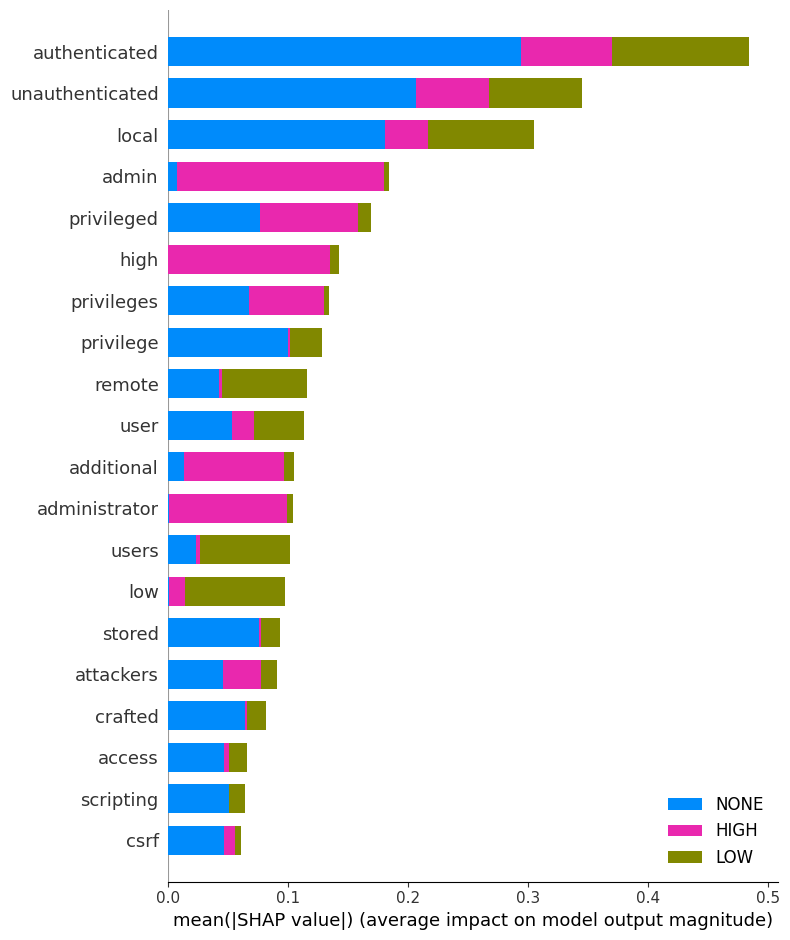

In [11]:
shap.summary_plot(PR_shap_values, PR_samples,max_display=20, class_names=PR_class_names, plot_type="bar")

### Attack Vector

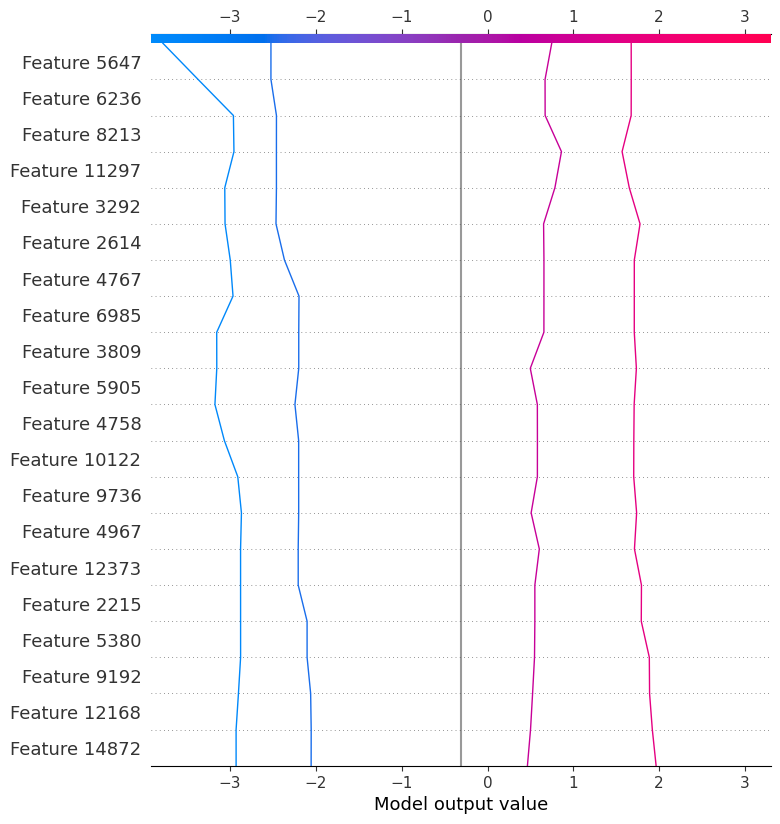

In [51]:
shap.multioutput_decision_plot(AV_expected_value, AV_shap_values, 0)

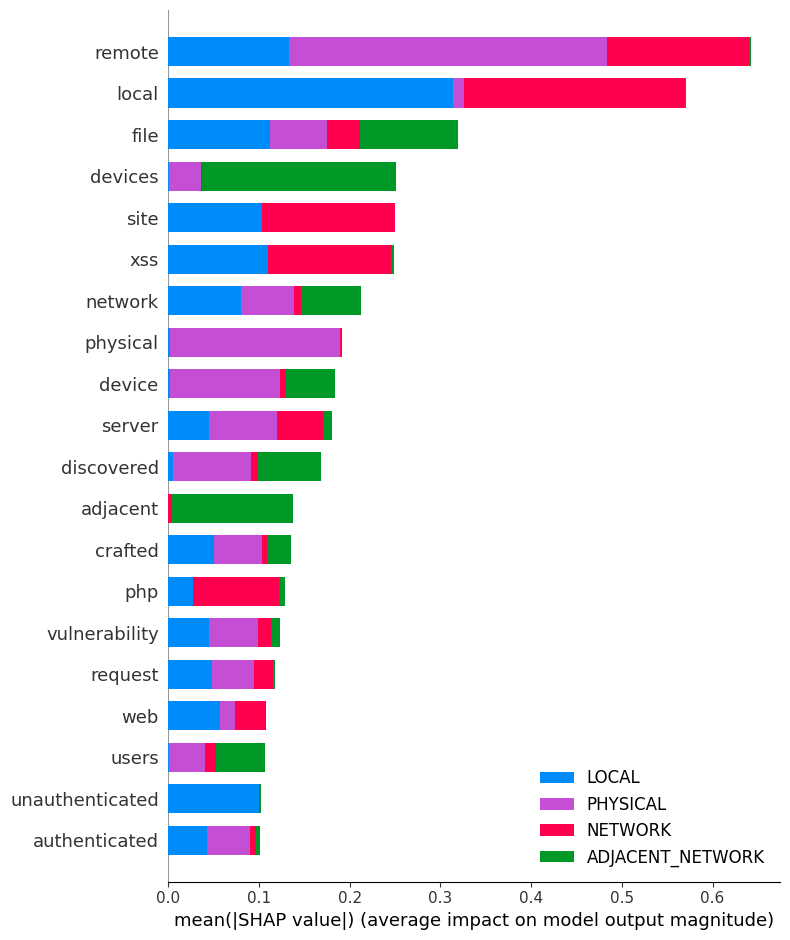

In [17]:
shap.summary_plot(AV_shap_values, AV_samples, max_display=20, cmap='Accent', class_names=AV_class_names, plot_type="bar")
# extract the numbers and give a by class analysis

In [78]:
shap.text_plot(shap_values,9)

AttributeError: 'list' object has no attribute 'shape'

## local Explanations

In [ ]:
import shap
S_samples = valid_texts
S_explainer, S_shap_values, S_expected_value, S_class_names = build_shap_values("scope", PR_samples)
S_class_names

In [ ]:
shap.initjs()
shap.force_plot(S_expected_value, S_shap_values[0],feature_names=valid_texts.columns)